In [8]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
import subprocess


data_dir = 'prep_result/summit'


In [9]:
import SimpleITK as sitk
from matplotlib import pyplot as plt
import os

workspace = Path(os.getcwd()).parent.parent

def copy_scan_from_cluster(scan_id, workspace):
    study_id = scan_id.split('_')[0]
   # now copy the src file
    if not os.path.exists(f"{workspace}/data/summit/scans/{study_id}/{scan_id}.mhd"):
        os.makedirs(f"{workspace}/data/summit/scans/{study_id}", exist_ok=True)

        command = [
            "scp",
            "-P 2222",
            f"jmccabe@localhost:/cluster/project2/SummitLung50/{study_id}/{scan_id}.*",
            f"{workspace}/data/summit/scans/{study_id}/."
        ]
        result = subprocess.run(command)
        print(result.stdout)
    else:
        print(f'{scan_id} already exists')

def read_mhd(file_path):
    itk_image = sitk.ReadImage(file_path)
    scan = sitk.GetArrayFromImage(itk_image)
    return scan, itk_image.GetSpacing(), itk_image.GetDirection(), itk_image.GetOrigin()

def show_nodule(scan_id, x, y, z, d, workspace):
    scan, spacing, orientation, origin = read_mhd(f"{workspace}/data/summit/scans/{scan_id.split('_')[0]}/{scan_id}.mhd")

    print(spacing)

    # Convert x, y, z to row, col, index
    row = int((x - origin[0]) / spacing[0])
    col = int((y - origin[1]) / spacing[1])
    idx = int((z - origin[2]) / spacing[2])

    print(f'{scan_id} - x: {x}, y: {y}, z: {z}, d: {d} / row: {row}, col: {col}, idx: {idx}, scan shape: {scan.shape}')
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(scan[idx,:,:], cmap='gray')
    circle = plt.Circle((row, col), d, color='r', fill=False)
    ax.add_artist(circle)
    plt.show()


In [17]:
# Check if any labels have negative values

labels = (
    pd.read_csv('prep_result/summit/labels.csv', index_col=0)
    .rename(columns={'0': 'idx', '1': 'row', '2': 'col', '3': 'd'})
)

metadata = (
    pd.concat([
        pd.read_csv(f'{workspace}/metadata/summit/optimisation/{ds}_metadata.csv', usecols=['scan_id','nodule_x_coordinate', 'nodule_y_coordinate', 'nodule_z_coordinate', 'nodule_diameter_mm'])
        for ds in ['training', 'validation', 'test', 'holdout']
    ])
)

shapes = (
    pd.read_csv('prep_result/summit/shapes.csv')
    .rename(columns={'id' : 'scan_id', '0': 'c_dim', '1': 'idx_dim', '2': 'row_dim', '3': 'col_dim'})
)

qc_data = (
    pd.merge(labels, shapes, on='scan_id')
    .assign(row_diff=lambda df: df.row - df.row_dim)
    .assign(col_diff=lambda df: df.col - df.col_dim)
    .assign(idx_diff=lambda df: df.idx - df.idx_dim)
)

nodules_outside_scan_dims = qc_data.query('row_diff > 0 | col_diff > 0 | idx_diff > 0')

negative_labels = qc_data.query('row < 0 | col < 0 | idx < 0 | d < 0')

display(nodules_outside_scan_dims.scan_id.unique())
display(negative_labels.scan_id.unique())

array(['summit-9754-pkv_Y0_BASELINE_A', 'summit-2625-nvf_Y0_BASELINE_A',
       'summit-8935-guu_Y0_BASELINE_A', 'summit-4236-sar_Y0_BASELINE_A',
       'summit-3399-wdd_Y0_BASELINE_A'], dtype=object)

array(['summit-5628-vrn_Y0_BASELINE_A', 'summit-6597-erv_Y0_BASELINE_A',
       'summit-4236-sar_Y0_BASELINE_A', 'summit-6344-jbm_Y0_BASELINE_A'],
      dtype=object)

summit-9754-pkv_Y0_BASELINE_A not found in metadata
summit-8935-guu_Y0_BASELINE_A not found in metadata
summit-3399-wdd_Y0_BASELINE_A already exists
(0.652344, 0.652344, 0.625)
summit-3399-wdd_Y0_BASELINE_A - x: 76.65, y: 22.31, z: -119.74, d: 4.8 / row: 385, col: 290, idx: 211, scan shape: (420, 512, 512)


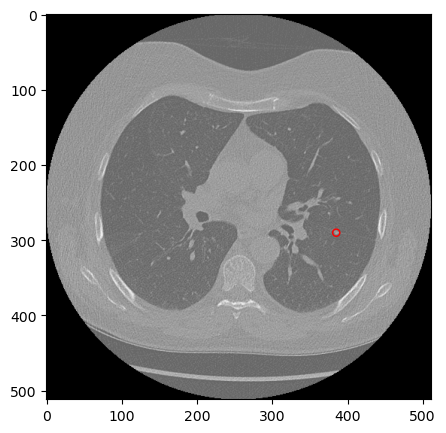

summit-3399-wdd_Y0_BASELINE_A already exists
(0.652344, 0.652344, 0.625)
summit-3399-wdd_Y0_BASELINE_A - x: -52.11, y: 48.76, z: -28.95, d: 4.6 / row: 188, col: 330, idx: 356, scan shape: (420, 512, 512)


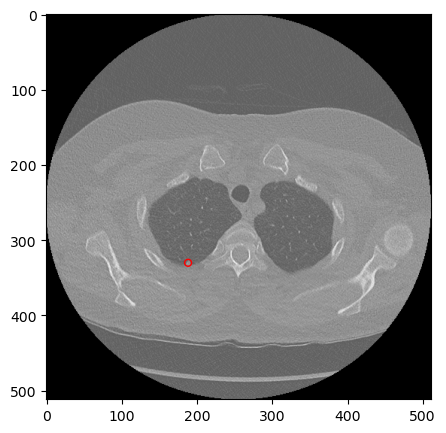

summit-3399-wdd_Y0_BASELINE_A already exists
(0.652344, 0.652344, 0.625)
summit-3399-wdd_Y0_BASELINE_A - x: 66.54, y: 145.35, z: -69.5, d: 18.0 / row: 370, col: 478, idx: 291, scan shape: (420, 512, 512)


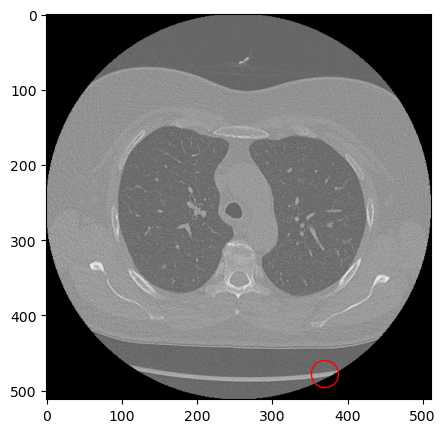

In [171]:

for scan_id in nodules_outside_scan_dims.scan_id.unique():

    md = metadata.query(f'scan_id == "{scan_id}"')
    
    if md.empty:
        print(f'{scan_id} not found in metadata')
        continue

    for i, row in md.iterrows():
    
        copy_scan_from_cluster(scan_id, workspace)
        show_nodule(scan_id, row['nodule_x_coordinate'], row['nodule_y_coordinate'], row['nodule_z_coordinate'], row['nodule_diameter_mm'], workspace)


summit-5628-vrn_Y0_BASELINE_A
summit-5628-vrn_Y0_BASELINE_A already exists
[[-40.37      157.38      234.7999939   0.       ]]
(299, 232, 315)


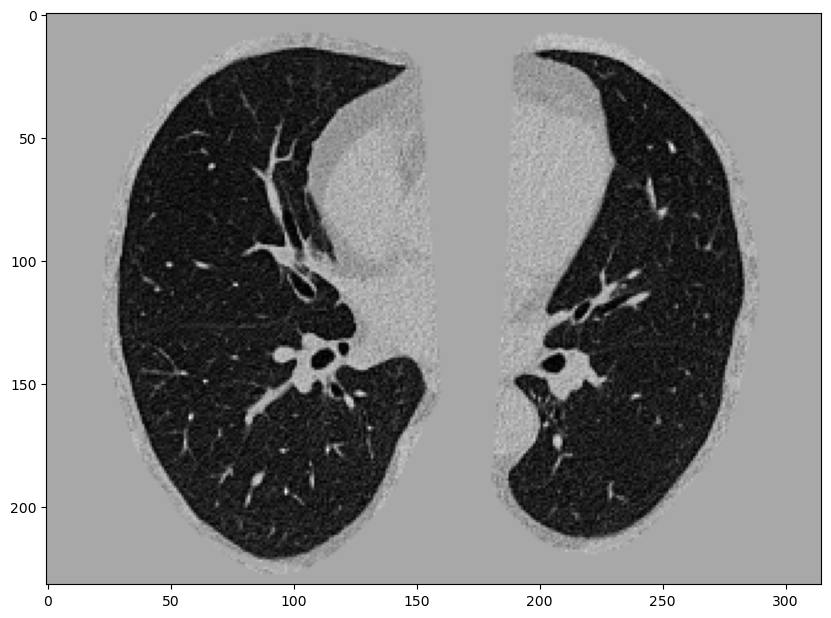

In [7]:
def copy_npy_from_cluster(scan_id, workspace):
    
    if not Path(f"{workspace}/models/grt123/prep_result/summit/{scan_id}_clean.npy").exists():
    
        command = [
            "scp",
            "-P 2222",
            f"jmccabe@localhost:/cluster/project2/SUMMIT/cache/sota/grt123/prep_result/summit/{scan_id}_clean.npy",
            f"{workspace}/models/grt123/prep_result/summit/."
        ]
        result = subprocess.run(command)
        print(result.stdout)

    if not Path(f"{workspace}/models/grt123/prep_result/summit/{scan_id}_label.npy").exists():
        command = [
            "scp",
            "-P 2222",
            f"jmccabe@localhost:/cluster/project2/SUMMIT/cache/sota/grt123/prep_result/summit/{scan_id}_label.npy",
            f"{workspace}/models/grt123/prep_result/summit/."
        ]
        result = subprocess.run(command)
        print(result.stdout)

# for scan_id in list(negative_labels.scan_id.unique()) + list(nodules_outside_scan_dims.scan_id.unique()):

for scan_id in ['summit-5628-vrn_Y0_BASELINE_A']:

    print(scan_id)
    copy_npy_from_cluster(scan_id, workspace)
    copy_scan_from_cluster(scan_id, workspace)
    clean = np.load(f'prep_result/summit/{scan_id}_clean.npy')
    label = np.load(f'prep_result/summit/{scan_id}_label.npy')
    print(label)
    print(clean.squeeze().shape)
    mid_idx = clean.squeeze().shape[0] // 2
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(clean.squeeze()[mid_idx, :, :], cmap='gray')
    plt.show()